In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

In [5]:
# Set random seed
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Enhanced data preprocessing with augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")

Loading CIFAR-10 dataset...


100%|██████████| 169M/169M [02:28<00:00, 1.14MB/s] 


Extracting ./data\cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Training samples: 50000
Test samples: 10000


In [7]:
# Deeper CNN with BatchNorm and improved architecture
class DeeperCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(DeeperCNN, self).__init__()
        
        # Block 1: 3 -> 64
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25)
        )
        
        # Block 2: 64 -> 128
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25)
        )
        
        # Block 3: 128 -> 256
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25)
        )
        
        # Block 4: 256 -> 512
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1024),  # 32->16->8->4->2, so 2x2 spatial size
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 100)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.classifier(x)
        return x

In [8]:
# Initialize model
model = DeeperCNN().to(device)
print(model)

DeeperCNN(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, strid

In [9]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 7,366,564
Trainable parameters: 7,366,564


In [10]:
# Loss and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training function
def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(trainloader)}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, testloader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(testloader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

In [11]:
# Training loop
print("\nStarting training...")
num_epochs = 20
train_losses, train_accs = [], []
test_losses, test_accs = [], []
learning_rates = []

start_time = time.time()

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, testloader, criterion, device)
    
    # Step scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    print(f'Learning Rate: {current_lr:.6f}')

total_time = time.time() - start_time
print(f'\nTraining completed in {total_time:.2f} seconds')


Starting training...

Epoch 1/20
--------------------------------------------------
Batch 0/391, Loss: 4.6580, Acc: 0.78%
Batch 100/391, Loss: 4.2948, Acc: 2.28%
Batch 200/391, Loss: 4.1156, Acc: 3.74%
Batch 300/391, Loss: 3.9798, Acc: 4.46%
Train Loss: 4.1910, Train Acc: 5.16%
Test Loss: 3.8538, Test Acc: 8.86%
Learning Rate: 0.001000

Epoch 2/20
--------------------------------------------------
Batch 0/391, Loss: 3.9909, Acc: 5.47%
Batch 100/391, Loss: 3.9312, Acc: 8.36%
Batch 200/391, Loss: 3.7800, Acc: 8.77%
Batch 300/391, Loss: 3.8514, Acc: 9.30%
Train Loss: 3.8437, Train Acc: 9.67%
Test Loss: 3.5278, Test Acc: 14.37%
Learning Rate: 0.001000

Epoch 3/20
--------------------------------------------------
Batch 0/391, Loss: 3.7030, Acc: 8.59%
Batch 100/391, Loss: 3.7765, Acc: 12.45%
Batch 200/391, Loss: 3.4720, Acc: 12.85%
Batch 300/391, Loss: 3.6502, Acc: 13.22%
Train Loss: 3.6110, Train Acc: 13.60%
Test Loss: 3.2159, Test Acc: 20.82%
Learning Rate: 0.001000

Epoch 4/20
---------

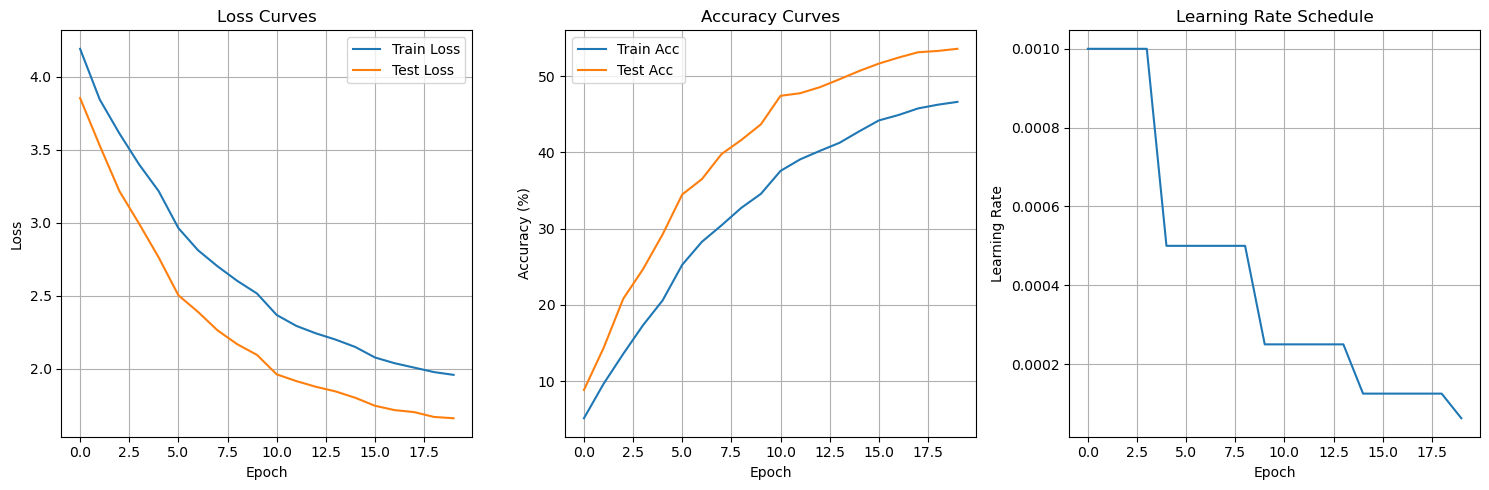

In [12]:
# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(learning_rates)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)

plt.tight_layout()
plt.show()

In [18]:
# Final results summary
print(f"\n" + "="*60)
print("CIFAR-100 Deeper CNN Results Summary")
print("="*60)
print(f"Final Train Accuracy: {train_accs[-1]:.2f}%")
print(f"Final Test Accuracy: {test_accs[-1]:.2f}%")
print(f"Best Test Accuracy: {max(test_accs):.2f}%")
print(f"Total Parameters: {total_params:,}")
print(f"Total Epochs: {num_epochs}")
print(f"Training Time: {total_time:.2f} seconds")


CIFAR-100 Deeper CNN Results Summary
Final Train Accuracy: 46.62%
Final Test Accuracy: 53.57%
Best Test Accuracy: 53.57%
Total Parameters: 7,366,564
Total Epochs: 20
Training Time: 600.31 seconds


In [14]:
# Get class names from dataset
classes = trainset.classes

# Per-class accuracy
model.eval()
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))

with torch.no_grad():
    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        c = (predicted == target).squeeze()
        for i in range(target.size(0)):
            label = target[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print("Per-class Test Accuracy:")
for i in range(100):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f'{classes[i]}: {acc:.2f}%')

Per-class Test Accuracy:
apple: 80.00%
aquarium_fish: 62.00%
baby: 35.00%
bear: 31.00%
beaver: 38.00%
bed: 59.00%
bee: 68.00%
beetle: 47.00%
bicycle: 69.00%
bottle: 66.00%
bowl: 33.00%
boy: 30.00%
bridge: 59.00%
bus: 47.00%
butterfly: 37.00%
camel: 50.00%
can: 60.00%
castle: 83.00%
caterpillar: 27.00%
cattle: 52.00%
chair: 84.00%
chimpanzee: 82.00%
clock: 42.00%
cloud: 64.00%
cockroach: 82.00%
couch: 33.00%
crab: 46.00%
crocodile: 38.00%
cup: 72.00%
dinosaur: 51.00%
dolphin: 55.00%
elephant: 57.00%
flatfish: 49.00%
forest: 51.00%
fox: 51.00%
girl: 39.00%
hamster: 55.00%
house: 62.00%
kangaroo: 32.00%
keyboard: 65.00%
lamp: 44.00%
lawn_mower: 68.00%
leopard: 47.00%
lion: 69.00%
lizard: 26.00%
lobster: 24.00%
man: 31.00%
maple_tree: 48.00%
motorcycle: 90.00%
mountain: 70.00%
mouse: 19.00%
mushroom: 56.00%
oak_tree: 87.00%
orange: 69.00%
orchid: 67.00%
otter: 11.00%
palm_tree: 83.00%
pear: 61.00%
pickup_truck: 72.00%
pine_tree: 42.00%
plain: 82.00%
plate: 56.00%
poppy: 61.00%
porcupine: 4